# Unlocking Player Behavior: *Predicting Newsletter Subscription Based on Gaming Patterns* 
### DSCI100_Group 42

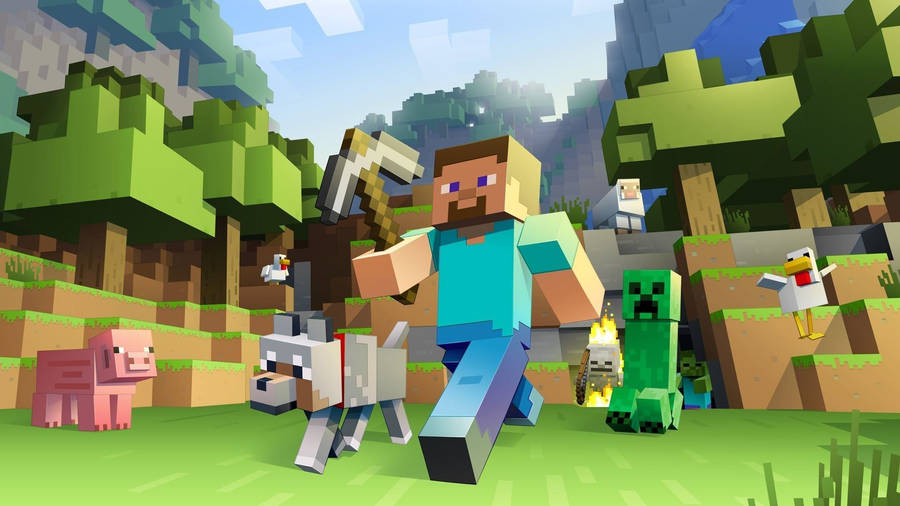

## Introduction

In 2023, a Minecraft server called PLAICRAFT was created by a group of students from the University of British Columbia (UBC) as part of an ongoing exploration into player engagement and behaviour in online gaming environments. PLAICRAFT's goal is to collect over 10,000 hours of multiplayer Minecraft gameplay data to build realistic game Non-Player Characters (NPCs) and support AI research (Smith, 2023). Through gamer volunteers, the UBC research group began collecting gameplay-related data to better understand how individuals interact with both in-game features and external community tools. 

Our project aims to identify which types of players are most likely to stay engaged beyond the game itself, through newsletters, and what personal or behavioural characteristics contribute to that engagement.

Online games attract a wide range of players because they allow for diverse play styles including: creative, competitive, social, or exploratory. Research has shown that different demographic and behavioural characteristics shape how players participate in digital spaces. Younger players often interact with fast-paced features more actively (Wohn, 2014), while more experienced players tend to engage more deeply with community-driven aspects of games (Yee, 2006). Although gender differences have also been documented, scholars caution against using gender as a predictive feature in computational models because doing so can reinforce stereotypes and obscure biases within datasets (D’Ignazio & Klein, 2020).
    
These concerns are especially relevant in the dataset we will use, where the vast majority of players identify as male. This demographic imbalance introduces a sampling bias that makes gender-based predictions unreliable and ethically questionable. For this reason, gender is included only descriptively in our exploratory analysis and is not used as a predictor variable in our final model.

Using the dataset collected by PLAICRAFT's research group, our investigation aims to determine whether certain player characteristics are associated with higher levels of community engagement. More specifically, we ask:
        
    How do player characteristics including total hours played, experience level, and age predict the likelihood of newsletter subscription?

Before modelling, we must conduct exploratory data analysis to understand the structure of our data! Throughout this report, we'll be using the `players.csv` dataset. 

## Data Exploration & Visualization

Let's load our libraries and the `players.csv` dataset that we will be working with.

In [ ]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(themis)

url <- "https://raw.githubusercontent.com/rhovestad/dsciprojectrh/main/players.csv"
players <- read_csv(url)

head(players)

#### Data Visualization

To get a better idea of the distribution of relevant variables, let's visualize the data using histograms and bar charts.

In [ ]:
subscribe <- players |> 
ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Did they Subscribe", y = "Count") +
    ggtitle("Figure 1: Are Players Subscribed to the Gaming Newsletter?") +
    theme(text = element_text(size = 14))
subscribe

experience <- players |> 
    ggplot(aes(x = experience, fill = experience)) +
    geom_bar() +
    labs(title = "Figure 2: Distribution of the Players' Ex", x = "Experience Level", y = "Count") +
    theme(text = element_text(size = 14)) 
experience

age_distribution <- players |> 
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 5, fill = "purple") +
    labs(x = "Age of Player", y = "Count") +
    ggtitle("Figure 3: Distribution of Ages of Players") +
    theme(text = element_text(size = 12))
age_distribution

play_distribution <- players |> 
ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 0.5, fill = "blue") +
    labs(x = "Number of hours played", y = "Count") +
    ggtitle("Figure 4: Distribution of Number of Hours Played by Gamers") +
    theme(text = element_text(size = 14))
play_distribution


#### Data Visualization Analysis

From a glance, we can note serveral distinct features of the distributions of our variables. 

Looking at **Figure 1**, we can see that more than half of the gamers chose to subscribe to the newsletter. 

**Figure 2** shows us that most gamers self-identified as Amateur, and Pro was least chosen. 

**Figure 3** shows us that the majority of gamers were just under 20. Considering that this is a project created by UBC students, we can guess that majority of gamers are university students.

Looking at **Figure 4**, we can note that our graph is significantly skewed to the right, thus most players only played for a very short period of time. With Minecraft being a very long and complex game that requires many different steps to complete the game, having gamers who only played for such brief amounts of time may not make the data very accurate in terms of what true Minecraft gamers look like. 

#### Data Description

Let's see what we can note about the data. We already learned a lot about the variables through data visualization, but let's look at statistics now!

In [ ]:
stats_summary <- players |>
summarise(mean_age = mean(Age, na.rm = TRUE),
    sd_age = sd(Age, na.rm = TRUE),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    sd_played_hours = sd(played_hours, na.rm = TRUE),
    min_played_hours = min(played_hours, na.rm = TRUE),
    max_played_hours = max(played_hours, na.rm = TRUE), 
    median_played_hours = median(played_hours, na.rm = TRUE), 
    median_age = median(Age, na.rm = TRUE))
stats_summary

newsletter <- players |>
    count(subscribe)
newsletter

nrow(players) 
ncol(players)

gender <- players |>
   count(gender)
gender

#### Summary Statistics
- Number of observations (rows): 196
- Number of variables (columns): 7
- Our maximum `played_hours` is (hours): 223.1
- Our minimum `play_hours` is (hours): 0
- Number of newsletter subscribers: 144
- Number of non-subscribers: 52
- Mean of `Age`: 21.14
- Standard Deviation of `Age`: 7.39
- Median of `Age`: 19
- Mean of `played_hours`: 5.85
- Standard Deviation of `played_hours`: 28.36

- Median of `played_hours`: 0.1

## Research Question

#### How do player characteristics including total hours played, experience level, and age predict the likelihood of newsletter subscription?


Now that we've completed our Data Exploration we can begin our model! 

We will use K-NN classification to solve our research question because it is an effective method for predicting categorical outcomes, such as whether a player subscribes to a newsletter. K-NN works by comparing a player's characteristics (e.g., age, hours played, experience) to those of other players in the dataset. It then predicts the outcome (subscription or not) based on the majority outcome of the most similar players making it ideal for predicting subscription likelihood based on players' characteristics.

Before we start our K-NN classification, let's clean our data!

We will transform the `subscribe` and `experience` variables into factors since they are currently categorical. We will also remove any irrelevant variables that won't be used in the model, in this case, that will be all identifier variables and `gender`. Lastly, we will remove observations with missing values to ensure our dataset is complete and ready for analysis. The cleaned dataset will be stored in the `clean_players` variable.

In [ ]:
clean_players <- players |>
    mutate(subscribe = as.factor(subscribe),
           experience = as.factor(experience)) |>
    select(-hashedEmail, -gender, -name) |>
    filter(!is.na(Age)) |>
    filter(!is.na(experience)) |>
    filter(!is.na(subscribe))

head(clean_players)

#### Setting Up Training and Testing Data

We first need to set a random seed for reproducibility. Now, to start our K-NN classification, we use the `initial_split` function to split our cleaned dataset. 70% of the data will be used for training our model, while the remaining 30% will be used for testing it. We do this because we want to train the algorithm with our data, but still be able to test using the same data.

In [ ]:
set.seed(6666)
players_split <- initial_split(clean_players, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#### Creating a Recipe and Model

Our next step is to create a recipe. A recipe defines the preprocessing steps we want to apply to our dataset before executing the analysis. In this case, our target variable is `subscribe`, and we will use `Age`, `played_hours`, and `experience` as predictor variables. To ensure that no single variable dominates the model due to scale differences, we will scale and center `Age` and `played_hours`. To help our model, we're also going to upsample the `subscribe` variable. This step will prevent the model from being biased towards the majority class (i.e. players who did subscribe).

Finally, we will use the `nearest_neighbors` function to specify that our analysis will use K-NN classification.

In [ ]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(Age, played_hours) |>
    step_center(Age, played_hours) |>
    step_upsample(subscribe, over_ratio = 2, skip = TRUE)
players_recipe
set.seed(6666)
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec_tuned

#### Using 5 Fold Cross Validation and Train the Model

Now, we will set up 5-fold cross-validation for the training set. Cross-validation will evaluate the performance of each model with different k-values by training on a portion of the data and testing it on the remaining part. This process is repeated multiple times to obtain an average result. This step provides a more reliable estimate of our algorithm's ability to predict the `subscribe` variable through its multiple tests. 

We're going to define our grid by creating a tibble and by giving a large range for the neighbors parameter in our K-NN model. 

Finally, we're going to set up our workflow. We want to combine our recipe, our type of model, and the cross-validation. 

In [ ]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

knn_tuned_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tuned) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()
knn_tuned_fit

#### Visualize Accuracy with Different K Values

Now that we've fully trained our model, it's time to visualize the accuracy for each value of k (number of neighbors). To do so, we want to create a plot that visualizes the relationship between k and its accuracy.  

In [ ]:
# Filters and selects only rows that are accuracy metric
accuracy <- knn_tuned_fit |>
    filter(.metric == "accuracy")

accuracy_plot <- accuracy |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    labs(x = "Number of Neighbors",
         y = "Mean Value of Accuracy") +
    ggtitle("Figure 5: The Relationship between Number of Neighbors (k) and Accuracy") +
    theme(text = element_text(size = 11))
accuracy_plot

#### Find the Best K and Fitting it in Training Data

From our visual, we can use the function `slice_max` to find the number of k-neighbors with the highest accuracy. This will also allow us to know the optimal number of neighbours to use in our final model, and we will name this `best_k`. 

With `best_k`, we will specify our optimal model! We'll create our final workflow, which again, will combine all of our previous steps — now with our `best_k`!

In [ ]:
# Finding the best number of neighbors for our model
best_k <- accuracy |>
    slice_max(mean) |>
    pull(neighbors)
best_k

# Optimizing model with new value of k
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Our final workflow!
knn_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_best) |>
    fit(players_test)

#### Predict Using Testing Data

After training the K-NN model with the optimal number of neighbors (k = 53), We are going to use the test dataset to make predictions on the `subscribe` variable. We're going to evaluate the model’s performance using accuracy. 

In [ ]:
subscribe_predictions <- predict(knn_best_fit, players_test) |>
    bind_cols(players_test)

subscribe_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)

subscribe_metrics
subscribe_predictions

**The model achieves an accuracy of 59.32%**, meaning it correctly predicts the subscription status of players about 59% of the time. 

These results suggest that the model performs decently. There may still be room for improvement in terms of agreement between predicted and true outcomes. 

## Discussion

### Summary

To reiterate, our project explored: **How do player characteristics including total hours played, experience level, and age predict the likelihood of newsletter subscription?** We used a K-Nearest Neighbours (K-NN) classification model to tune and select the optimal number of neighbours, which was k = 53.

**The final model achieved an accuracy of 59.32% on the testing data**, meaning it correctly classified subscription status only a little better than chance. The kappa value was 0.1927, indicating low agreement between the model’s predictions and the actual subscription outcomes. The model performed only slightly better than random guessing.

These metrics showed that although the model correctly identified some true subscribers, its overall predictive power was limited. The prediction table also showed some misclassifications present across both subscriber and non-subscriber groups.

Despite limited predictive power, the results still suggest that behavioural variables such as `experience` and `played_hours` appear to be more meaningful predictors of subscription behaviour than `Age`. In the raw data and predicted vs. actual outcomes, subscribers tended to show more variation in experience level and gameplay hours. At the same time, age showed almost no separation between the groups.


### Expectations

The findings partly aligned with our expectations. We initially hypothesized that player characteristics like total hours played, experience level, and age would predict the likelihood of newsletter subscription. The K-NN classification results support the idea that behavioural predictors such as experience level and total hours carry more weight than demographic predictors like age, which partially supports this view. 

However, the model’s modest accuracy (~59%) was lower than expected, even though the classes were balanced through upsampling, suggesting the three predictors (`experience`, `played_hours`, `Age`) did not provide enough information to reliably classify `subscription`. Subscription behaviour may be driven by additional unmeasured factors such as social influence or in-game engagement patterns that were not included in our dataset.

### Impact of such findings

The results still offer useful insights even though the predictive accuracy was limited. Players with more experience or played hours may show a slightly greater likelihood of subscribing to the newsletter. PLAICRAFT's creators could adjust in-game content, suggest newsletters and updates, and host events to boost engagement among experienced players. Meanwhile, they could create more innovative features to help newer players connect more deeply with the game content.

### Future questions

Our results raise a few important questions for future exploration:

- What additional predictors (e.g. social engagement, in-game achievements, motivation) would enhance the accuracy of our prediction?
- If we apply other models like linear regression, would we obtain a more reliable estimate of player subscription compared to K-NN classification?
- Does subscription behaviour generalize to different groups or communities and not just Minecraft fans?

Addressing these questions would strengthen our understanding of online engagement patterns, and allow PLAICRAFT to reach its goal of 10,000 hours played. The greater understa


## References

D’Ignazio, C., & Klein, L. F. (2020). Data Feminism. MIT Press. https://data-feminism.mitpress.mit.edu/

Smith, A. (2023, September 28). plaicraft.ai launch - Pacific Laboratory for Artificial Intelligence. Pacific Laboratory for Artificial Intelligence; University of British Columbia. https://plai.cs.ubc.ca/2023/09/27/plaicraft/

Wohn, D. Y. (2014). Spending real money: Purchasing patterns of virtual goods in an online social game. Computers in Human Behavior, 38, 1–10. https://doi.org/10.1016/j.chb.2014.05.001

Yee, N. (2006). Motivations for play in online games. CyberPsychology & Behavior, 9(6), 772–775. https://doi.org/10.1089/cpb.2006.9.772 